<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Homework/NGupta_homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model 
import bert
import tensorflow_hub as hub

In [3]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [4]:
# Set up tokenizer to generate Tensorflow dataset
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [20]:
max_seq_length = 50  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
classifier1 = tf.keras.layers.Dense(100,activation='sigmoid')(pooled_output)
classifier2 = tf.keras.layers.Dense(1,activation='sigmoid')(classifier1)

In [21]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[classifier2])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

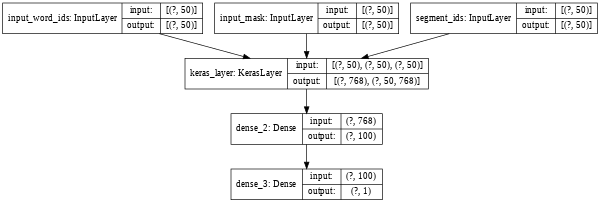

In [22]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [8]:
tokens = tokenizer.tokenize("cyclohexane was on the test")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['cy', '##cl', '##oh', '##ex', '##ane', 'was', 'on', 'the', 'test']
[22330, 20464, 11631, 10288, 7231, 2001, 2006, 1996, 3231]


In [9]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [11]:
def encode_sentence(s):
   tokens = [i for i in list(tokenizer.tokenize(s))]
   tokens = tokens[1:]
   return np.array(tokenizer.convert_tokens_to_ids(tokens))

def bert_encode(x_data, tokenizer, seq_len):
  num_examples = len(x_data)
  
  data = []
  for i in x_data:
    tmp = encode_sentence(i)
    if len(tmp) > seq_len-1:
      tmp = tmp[0:seq_len-1]
    data.append(tmp)
  sentence = tf.ragged.constant(data)
 
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'segment_ids': input_type_ids}

  return inputs

In [12]:
from tensorflow.keras.datasets import imdb
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)

In [13]:
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
reverse_index = dict([(value, key) for (key, value) in word_index.items()]) 
decoded = " ".join( [reverse_index.get(i,"?") for i in training_data[0]] )
print(decoded) 

<STAR


In [14]:
tokens = tokenizer.tokenize(decoded)
print(tokens)
encode_sentence(decoded)

['<', 'start', '>', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', 'everyone', "'", 's', 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', '<', 'un', '##k', '>', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', '<', 'un', '##k', '>', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', '<', 'un', '##k', '>', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'fishing', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 'it', 'was', 'so', 'sad', 'and', 'y

array([ 2707,  1028,  2023,  2143,  2001,  2074,  8235,  9179,  3295,
       17363,  2466,  3257,  3071,  1005,  1055,  2428, 10897,  1996,
        2112,  2027,  2209,  1998,  2017,  2071,  2074,  5674,  2108,
        2045,  2728,  1026,  4895,  2243,  1028,  2003,  2019,  6429,
        3364,  1998,  2085,  1996,  2168,  2108,  2472,  1026,  4895,
        2243,  1028,  2269,  2234,  2013,  1996,  2168,  4104,  2479,
        2004,  2870,  2061,  1045,  3866,  1996,  2755,  2045,  2001,
        1037,  2613,  4434,  2007,  2023,  2143,  1996, 25591, 12629,
        2802,  1996,  2143,  2020,  2307,  2009,  2001,  2074,  8235,
        2061,  2172,  2008,  1045,  4149,  1996,  2143,  2004,  2574,
        2004,  2009,  2001,  2207,  2005,  1026,  4895,  2243,  1028,
        1998,  2052, 16755,  2009,  2000,  3071,  2000,  3422,  1998,
        1996,  4875,  5645,  2001,  6429,  2428,  6639,  2012,  1996,
        2203,  2009,  2001,  2061,  6517,  1998,  2017,  2113,  2054,
        2027,  2360,

In [15]:
def decode(seq):
  return " ".join( [reverse_index.get(i,"?") for i in seq] )
x_data = [decode(i) for i in training_data]
val_data = [decode(i) for i in testing_data]

In [16]:
x_data[:5]

["<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for w

In [17]:
x_data = bert_encode(x_data,tokenizer,max_seq_length)
val_data = bert_encode(val_data,tokenizer,max_seq_length)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.BinaryCrossentropy()
batch_size = 5
epochs = 1

model.compile(
    optimizer='rmsprop',
    loss=loss,
    metrics=metrics)

model.fit(
     x_data, training_targets,
     validation_data=(val_data, testing_targets),
      batch_size=batch_size,
      epochs=epochs)

xx = model.predict(x_data)

5000/5000 [==============================] - 564s 113ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000


For your homework:

1.   Run the network with batch size 5,10, 15 and 100.
2.   Repeat (1) but this time, re-run the notebook with seqience length 500
3.   What do you notice about the loss and accuracy?
4.   What does this tell you about BERT vs an RNN we used earlier

